# 数据集成与可视化


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants

from spdm.core.entry import open_entry
from spdm.core.function import Function
from spdm.view import sp_view

In [ ]:
import fytok

## 统一数据访问


### 通用资源定位符 URI

```
<local schema>+<protocol>+<format>://<address>/<path>?<query>#<fragment>
```

扩展 protocol

- schema : 指定数据语义，通常为装置名
- protocol : 指定数据协议，如 file 或 mdsplus
- format : 明确指定文件格式

标准语义

- address : 指定数据地址，如 IP 或主机名
- path : 指定数据路径
- query : 指定数据查询条件
- fragment : 指定数据片段


In [ ]:
from fytok.modules.wall import Wall

wall = Wall("east://#wall")

In [ ]:
desc = wall.description_2d[0]

In [ ]:
r = wall.description_2d[0].limiter.unit[0].outline.r

In [ ]:
fig = sp_view.display(wall)

In [ ]:
fig = sp_view.display(Wall("iter://#wall"))

In [ ]:
fig = sp_view.display(Wall("d3d://#wall"))

In [ ]:
fig = sp_view.display(Wall("cfetr://#wall"))

## 文件访问


In [ ]:
eqdsk_file = open_entry(f"file+geqdsk://./data/geqdsk.txt")

In [ ]:
psi_norm = eqdsk_file.get("equilibrium/profiles_1d/psi_norm")
f_value = eqdsk_file.get("equilibrium/profiles_1d/f")

In [ ]:
f_value

## 插值函数


In [ ]:
f = Function(psi_norm, f_value)
plt.plot(psi_norm, f_value)
x = np.linspace(0.01, 0.95, 32)
plt.plot(x, f(x), "+")

## 示例: 平衡分析


In [ ]:
from fytok.modules.equilibrium import Equilibrium

In [ ]:
equilibrium = Equilibrium("file+geqdsk://./data/geqdsk.txt#equilibrium")

In [ ]:
fig = sp_view.display(equilibrium)

In [ ]:
eq = equilibrium 
eq_profiles_2d = eq.profiles_2d
eq_profiles_1d = eq.profiles_1d

FyTok 会自动将一维数组转换样条插值函数


In [ ]:
x = np.linspace(0.01, 0.95, 20)
eq_profiles_1d.f(x)

In [ ]:
plt.plot(x, f(x))
plt.plot(x, -eq_profiles_1d.f(x), ".")

In [ ]:
astra_profiles = pd.read_excel("./data/profiles.xls", sheet_name=1, header=10, usecols="B:BN")

In [ ]:
R0 = equilibrium.vacuum_toroidal_field.r0
psi_axis = equilibrium.global_quantities.psi_axis
psi_boundary = equilibrium.global_quantities.psi_boundary
eq_profiles_1d: Equilibrium.Profiles1D = equilibrium.profiles_1d

fig = sp_view.plot(
    (eq_profiles_1d.grid.psi_norm[1:-1], r"$\bar{\psi}$[-]"),  # 横坐标
    (  # 分组显示
        [
            (
                Function(astra_profiles["xq"].values, astra_profiles["q"].values),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.q, {"label": r"fytok"}),
        ],
        {"y_label": r"$q [-]$"},
    ),
    (
        [
            (
                Function(astra_profiles["Fp"].values, astra_profiles["rho"].values),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.rho_tor),
        ],
        {
            "y_label": r"$\rho_{tor}[m]$",
        },
    ),
    (
        [
            (
                Function(astra_profiles["Fp"].values, astra_profiles["x"].values),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.rho_tor_norm),
        ],
        {
            "y_label": r"$\bar{\rho}_{tor}[-]$",
        },
    ),
    (
        [
            Function(
                astra_profiles["Fp"].values,
                4 * (scipy.constants.pi**2) * R0 * astra_profiles["rho"].values,  # type: ignore
                label=r"$4\pi R_0 \rho$",
            ),
            (eq_profiles_1d.dvolume_drho_tor, {"label": r"$\frac{dV}{d\bar{\rho}}$"}),
            (
                (scipy.constants.pi * 2.0)
                * eq_profiles_1d.dvolume_dpsi
                * eq_profiles_1d.dpsi_drho_tor,
                r"$\frac{dV}{d\psi} \cdot \frac{d\psi}{d\rho}$",
            ),
        ],
        {"y_label": r"$[m^2]$"},
    ),
)

In [ ]:
eq_profiles_1d: Equilibrium.Profiles1D = equilibrium.profiles_1d
fig = sp_view.plot(  # plot tokamak geometric profile
    eq_profiles_1d.grid.psi_norm[1:],
    (eq_profiles_1d.dvolume_dpsi, r"$\frac{dV}{d\psi}$"),
    (eq_profiles_1d.dpsi_drho_tor, r"$\frac{d\psi}{d\rho_{tor}}$"),
    (eq_profiles_1d.f, {"y_label": r"$F_{pol} [Wb\cdot m]$"}),
    (eq_profiles_1d.q, {"y_label": r"$q [-]$"}),
    ((eq_profiles_1d.rho_tor, r"$\rho$"), {"y_label": r"$\rho_{tor}[m]$"}),
    ((eq_profiles_1d.rho_tor_norm, r"$\bar{\rho}$"), {"y_label": r"[-]"}),
    (
        (eq_profiles_1d.dvolume_drho_tor, r"$dV/d\rho_{tor}$"),
        {"y_label": r"$4\pi ^ 2 R_0 \rho[m ^ 2]$"},
    ),
    (eq_profiles_1d.gm1, r"$gm1=\left<\frac{1}{R^2}\right>$"),
    (eq_profiles_1d.gm2, r"$gm2=\left<\frac{\left|\nabla \rho\right|^2}{R^2}\right>$"),
    (eq_profiles_1d.gm3, r"$gm3=\left<\left|\nabla \rho\right|^2\right>$"),
    (eq_profiles_1d.gm4, r"$gm4=\left<1/B^2\right>$"),
    (eq_profiles_1d.gm5, r"$gm5=\left<B^2\right>$"),
    (eq_profiles_1d.gm6, r"$gm6=\left<\nabla \rho_{tor}^2/ B^2 \right>$"),
    (eq_profiles_1d.gm7, r"$gm7=\left<\left|\nabla \rho\right|\right>$"),
    (eq_profiles_1d.gm8, r"$gm8=\left<R\right>$"),
    x_label=r"\bar{\psi}",
)

In [ ]:
from fytok.modules.equilibrium import Equilibrium

eq = Equilibrium("file+geqdsk://./data/geqdsk.txt#equilibrium")

fig = sp_view.display(eq)

# 示例: Tokamak 装置信息


In [1]:
from spdm.view import sp_view
from fytok.contexts.tokamak import Tokamak

2024-08-01 13:35:07,816 [    spdm]     INFO: 
########################################################################################################################
        ______      _____     _
       / ____/_  __|_   _|__ | | __
      / /_  / / / /  | |/ _ \| |/ /
     / __/ / /_/ /   | | (_) |   <
    /_/    \__, /    |_|\___/|_|\_\
          /____/

(C) 2021-2024 Zhi YU @ ASIPP. All rights reserved.
version: develop, spdm: 0.5.2.post1.dev3+ge211a76f.d20240801, ontology: imas/3
########################################################################################################################

2024-08-01 13:35:08,000 [   fytok]  VERBOSE: Using ontology: imas/3 (dummy) at fytok/mappings/{schema}/imas/3:spdm/mapping/{schema}/imas/3


In [2]:
tokamak = Tokamak(
    device="iter",
    shot=900003,
    equilibrium="file+geqdsk://./data/geqdsk.txt#equilibrium",
)

2024-08-01 13:35:08,093 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_xml


## 展示概要信息


展示模拟的概要信息，包括

- 装置名称、炮号、运行序号，
- 使用者、运行环境、运行时间、采用的 Ontology 版本
- 调用的模块信心


In [3]:
print(tokamak)

2024-08-01 13:35:08,267 [   fytok]  VERBOSE: Load module fytok.plugins.modules.equilibrium.fy_eq
2024-08-01 13:35:08,269 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_geqdsk
------------------------------------------------------------------------------------------------------------------------
    Device: ITER, Shot: 900003, Run: 0,
    Run by Salmon on Salmon at 2024-08-01T13:35:08.325869, base on ontology "modified imas/3" 
------------------------------------------------------------------------------------------------------------------------
- Context           : fy_tok-develop
- Actors/Processors :

- Components        : magnetics,pf_active,wall
------------------------------------------------------------------------------------------------------------------------



## 可视化

### 适用于 JupyterLab 环境的可视化接口

FyTok 提供了适用于 JupyterLab 环境的可视化接口，`sp_view.display()`调用。默认情况下，`Tokamak` 会将能够获取到的信息尽可能绘制到一张图上。如下图，展示了 pf_active 极向场线圈、magnetic 磁场探针，wall.limiter 壁, interferometer 干涉仪的几何信息，磁平衡信息给出了二维磁面的等高线，最外层磁面、磁轴、X-point 等信息。

```{note}
具有 IDS 可视化语义的 IDS 都应支持 `sp_view.display()` 可视化，如 wall,pf_active,equilibrium。关于可视化库 spdm.view 的进一步细节请参考第二部分 SpDM 的可视化章节。
```


In [4]:
profiles_2d = tokamak.equilibrium.profiles_2d

2024-08-01 13:35:08,353 [   fytok]  VERBOSE: Load module spdm.view.view_matplotlib
2024-08-01 13:35:08,460 [   fytok]  VERBOSE: Load module spdm.mesh.mesh_rectangular
2024-08-01 13:35:08,470 [   fytok]    ERROR: /home/salmon/workspace/spdm/python/spdm/model/context.py:120:__view__: Failed to get FyEq.__view__ ! 
Traceback (most recent call last):
  File "/home/salmon/workspace/spdm/python/spdm/model/context.py", line 118, in __view__
    g_view = g.__view__(**styles)
             ^^^^^^^^^^^^^^^^^^^^
  File "/home/salmon/workspace/fytok/python/fytok/modules/equilibrium.py", line 467, in __view__
    raise error
  File "/home/salmon/workspace/fytok/python/fytok/modules/equilibrium.py", line 418, in __view__
    self.global_quantities.magnetic_axis[0],
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/salmon/workspace/spdm/python/spdm/core/sp_tree.py", line 246, in __get__
    value = self.alias.get(instance, _not_found_)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/ho

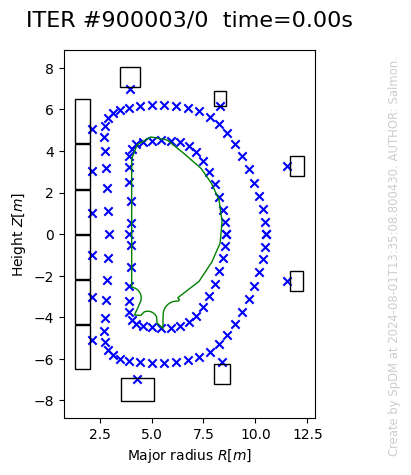

In [5]:
fig = sp_view.display(tokamak)

## 将可视化结果输出为图像文件

通过指定输出文件路径 `output=f"output/{tok.tag}_rz.svg"`，可以将可视化结果以文件的形式保存。


2024-08-01 13:35:09,133 [   fytok]    ERROR: /home/salmon/workspace/spdm/python/spdm/model/context.py:120:__view__: Failed to get FyEq.__view__ ! 
Traceback (most recent call last):
  File "/home/salmon/workspace/spdm/python/spdm/model/context.py", line 118, in __view__
    g_view = g.__view__(**styles)
             ^^^^^^^^^^^^^^^^^^^^
  File "/home/salmon/workspace/fytok/python/fytok/modules/equilibrium.py", line 467, in __view__
    raise error
  File "/home/salmon/workspace/fytok/python/fytok/modules/equilibrium.py", line 418, in __view__
    self.global_quantities.magnetic_axis[0],
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/salmon/workspace/spdm/python/spdm/core/sp_tree.py", line 246, in __get__
    value = self.alias.get(instance, _not_found_)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/salmon/workspace/spdm/python/spdm/core/path.py", line 509, in get
    return self.find(target, default_value=default_value)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

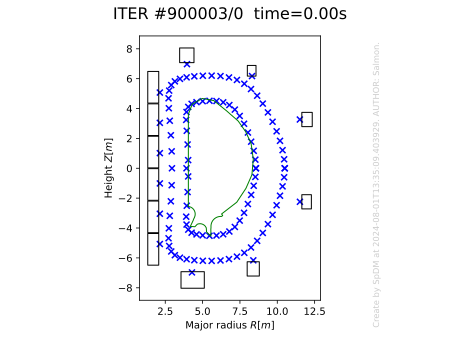

In [6]:
from IPython.core.display import SVG

sp_view.display(tokamak, title=tokamak.title, output=f"output/{tokamak.tag}_rz.svg")

SVG(f"output/{tokamak.tag}_rz.svg")